In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

from bilby.core.prior import (
    ConditionalPowerLaw,
    ConditionalPriorDict,
    Constraint,
    Cosine,
    Gaussian,
    LogNormal,
    PowerLaw,
    PriorDict,
    Sine,
    Uniform,
)

from bilby.gw.prior import UniformComovingVolume, UniformSourceFrame

from typing import TYPE_CHECKING, Optional, Union

msun = r"$M_{\odot}$"
mpc = "Mpc"
rad = "rad"

#from astropy.cosmology import Cosmology

In [3]:
from pycbc.filter import sigma
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate


rpm: symbol lookup error: /lib64/librpmio.so.9: undefined symbol: lzma_stream_encoder_mt, version XZ_5.2
/usr/bin/pkg-config: line 8: /usr/bin/-pkg-config: No such file or directory
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [4]:
#import bilby



def uniform_extrinsic() -> PriorDict:
    prior = PriorDict()
    prior["dec"] = Cosine()
    prior["ra"] = Uniform(0, 2 * np.pi)
    prior["theta_jn"] = Sine()
    prior["phase"] = Uniform(0, 2 * np.pi)
    return prior

def nonspin_bns() -> PriorDict:
    prior = uniform_extrinsic()
    prior["mass_1"] = Uniform(5, 100, unit=msun)
    prior["mass_2"] = Uniform(5, 100, unit=msun)
    prior["mass_ratio"] = Constraint(0, 1)
    prior["redshift"] = UniformSourceFrame(
        0, 0.5, name="redshift", cosmology=None
    )
    prior["psi"] = 0
    prior["a_1"] = 0
    prior["a_2"] = 0
    prior["tilt_1"] = 0
    prior["tilt_2"] = 0
    prior["phi_12"] = 0
    prior["phi_jl"] = 0

    detector_frame_prior = True
    return prior, detector_frame_prior

In [4]:
seed = np.random.seed(8810235)
sample = p.sample(1000)


NameError: name 'p' is not defined

In [4]:
#alpha value to be used for power law priors
powerlaw_alpha = -3.0

#prior functions to use for component masses.
mass1prior = Uniform
mass2prior = Uniform

mass1_min = 1.0
mass1_max = 3.0

mass2_min = 1.0
mass2_max = 3.0

#prior functions to use for spins. 
spin1zprior = Uniform
spin2zprior = Uniform

spin1z_min = 0.0
spin1z_max = 0.0

spin2z_min = 0.0
spin2z_max = 0.0

#prior functions to use for right ascension and declination.
#RA and DEC take ranges 0 <= x <= 1, and are transformed to their proper ranges.

ra_prior = Uniform #RA should always be uniform
dec_prior = Cosine

ra_min = 0.0
ra_max = 1.0

dec_min = 0.0
dec_max = 1.0

#prior function for distance. Should be either Uniform or UniformComovingVolume.

d_prior = UniformComovingVolume

d_min = 10.0
d_max = 100

#prior function for inclination. Should be Sine.

inc_prior = Sine

inc_min = 0.0
inc_max = 1.0

#prior function for polarization. Should be Uniform.

pol_prior = Uniform

pol_min = 0.0
pol_max = 1.0


In [5]:
def constructPrior(
    prior: Union[Uniform, Cosine, UniformComovingVolume,PowerLaw], 
    min: float, 
    max: float,
    **kwargs
) -> PriorDict:
    #generic constructor for bilby priors. 
    
    if prior == PowerLaw:
        kwargs['alpha'] = powerlaw_alpha

    if max <= min:
        return max
    else:
        return prior(minimum = min, maximum = max, **kwargs)

In [6]:
#intrinsic prior

prior = PriorDict()

prior['mass1'] = constructPrior(mass1prior, mass1_min, mass1_max)
prior['mass2'] = constructPrior(mass2prior, mass2_min, mass2_max)
prior['spin1z'] = constructPrior(spin1zprior, spin1z_min, spin1z_max)
prior['spin2z'] = constructPrior(spin2zprior, spin2z_min, spin2z_max)

prior['ra'] = constructPrior(Uniform, ra_min * 2 * np.pi, ra_max * 2 * np.pi, boundary = 'periodic')
prior['dec'] = constructPrior(dec_prior, np.pi * ra_min - np.pi/2, np.pi * ra_max - np.pi/2)

prior['d'] = constructPrior(d_prior, d_min, d_max, name = 'luminosity_distance')
prior['i'] = constructPrior(inc_prior, inc_min * np.pi, inc_max * np.pi)
prior['pol'] = constructPrior(pol_prior, pol_min * np.pi *2, pol_max * np.pi *2)

In [13]:
#extrinsic prior

exprior = PriorDict()

exprior['ra'] = constructPrior(Uniform, ra_min * 2 * np.pi, ra_max * 2 * np.pi, boundary = 'periodic')
exprior['dec'] = constructPrior(dec_prior, np.pi * ra_min - np.pi/2, np.pi * ra_max - np.pi/2)

exprior['d'] = constructPrior(d_prior, d_min, d_max, name = 'luminosity_distance')
exprior['i'] = constructPrior(inc_prior, inc_min * np.pi, inc_max * np.pi)
exprior['pol'] = constructPrior(pol_prior, pol_min * np.pi *2, pol_max * np.pi *2)

In [14]:
intrinsic = prior.sample(1000)
extrinsic = exprior.sample(1000)

In [17]:
from utils.noise_utils import get_valid_noise_times
gps, _, _ = get_valid_noise_times("noise/test/",1000)

In [21]:
gps = np.random.permutation(gps)

#get next gps time



In [31]:
psd = np.load("noise/test/psd.npy")

#load PSD into a FrequencySeries object using pycbc

from pycbc.types import FrequencySeries

psds = {}
psds["H1"] = FrequencySeries(psd[1], delta_f = 1.0/psd.shape[0], dtype = np.complex128)
psds["L1"] = FrequencySeries(psd[2], delta_f = 1.0/psd.shape[0], dtype = np.complex128)

In [244]:
psds["H1"] = interpolate(psds["H1"],delta_f=1/4)

In [8]:
def get_projected_waveform_mp(args,approximant = 'SpinTaylorT4', f_lower = 18.0, delta_t = 1.0/2048, detectors = ['H1','L1']):

    all_detectors = {'H1': Detector('H1'), 'L1': Detector('L1'), 'V1': Detector('V1')}

    hp, hc = get_td_waveform(mass1 = args['mass1'], mass2 = args['mass2'], 
                             spin1z = args['spin1z'], spin2z = args['spin2z'],
                             inclination = args['i'], distance = args['d'],
                             approximant = approximant, f_lower = f_lower, delta_t = delta_t)
    
    
    for detector in detectors:
        f_plus, f_cross = detectors[detector].antenna_pattern(
            right_ascension=extrinsic['ra'][n], declination=extrinsic['dec'][n],
            polarization=extrinsic['pol'][n],
            t_gps=gps[n])
        
        delta_t_h1 = detectors[detector].time_delay_from_detector(
            other_detector=detectors['H1'],
            right_ascension=extrinsic['ra'][n],
            declination=extrinsic['dec'][n],
            t_gps=gps[n])
        
        detector_signal = f_plus * hp + f_cross * hc
   
    return detector_signal

In [9]:
import multiprocessing as mp

In [15]:
intrinsic = [{key: intrinsic[key][i] for key in intrinsic.keys()} for i in range(len(intrinsic['mass1']))]

In [16]:
intrinsic = [{key: intrinsic[key][i] for key in intrinsic.keys()} for i in range(len(intrinsic['mass1']))]
with mp.Pool(processes = 20) as pool:
    waveforms = pool.map(get_projected_waveform_mp, intrinsic)



In [36]:
from pycbc.filter import sigma
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate

samples = 10
bads = 0

intrinsic = prior.sample(samples)

bad_is = []
bad_ds = []
all_snrs = []

for n in range(samples):

    hp, hc = get_td_waveform(mass1=intrinsic['mass1'][n], 
                            mass2=intrinsic['mass2'][n],                 
                            spin1z=intrinsic['spin1z'][n], 
                            spin2z=intrinsic['spin2z'][n],  
                            inclination = extrinsic['i'][n],
                            distance = extrinsic['d'][n],
                            delta_t=1.0/2048, 
                            f_lower=18.0, 
                            approximant='SpinTaylorT4')

    #hp.resize(len(hp) + 2048*10)
    #hc.resize(len(hc) + 2048*10)


    detectors = {'H1': Detector('H1'), 'L1': Detector('L1')}

    snrs = {}

    for detector in detectors:
        f_plus, f_cross = detectors[detector].antenna_pattern(
            right_ascension=extrinsic['ra'][n], declination=extrinsic['dec'][n],
            polarization=extrinsic['pol'][n],
            t_gps=gps[n])
        
        delta_t_h1 = detectors[detector].time_delay_from_detector(
            other_detector=detectors['H1'],
            right_ascension=extrinsic['ra'][n],
            declination=extrinsic['dec'][n],
            t_gps=gps[n])
        
        print(f_plus,f_cross)
        
        detector_signal = f_plus * hp + f_cross * hc

        snr = sigma(htilde=detector_signal,
                        psd=interpolate(psds[detector], delta_f=detector_signal.delta_f),
                        low_frequency_cutoff=20.0)
        
        snrs[detector] = snr


    network_snr = np.sqrt(sum([snrs[detector]**2 for detector in snrs]))

    all_snrs.append(network_snr)
    if network_snr < 4.0:
        bads += 1
        bad_is.append(extrinsic['i'][n])
        bad_ds.append(extrinsic['d'][n])
        

    #print(network_snr)
#fraction of bad samples

print(bads/samples)

-0.46180255092806577 -0.24832855027138018
0.45316941029912094 0.48042659773674645
0.6984853637415291 -0.23278754163079377
-0.46649349456675615 -0.07284979738442293
-0.3651941908951033 0.7465339824565165
0.4998840373513933 -0.5656402021368521
-0.1808751611712927 0.5184842208087838
0.40933257472861695 -0.5327125036390008
-0.6052519760444377 0.4606858064920926
0.6797825843505011 -0.6626958521032675
-0.5919422651469561 0.1761120481755364
0.3761109662557903 -0.32553461362583647
0.3514928581373937 -0.3259103307959106
-0.13780206611423193 0.3335353592104388
0.3445405931177782 -0.7442898333281175
-0.3403548970412877 0.44710550695552265
-0.13150116055676273 0.29784741675430715
0.45933830876874926 -0.47442593245299103
-0.27774536762708923 0.06534758623009604
-0.16410288695580938 -0.07535332464076624
0.0


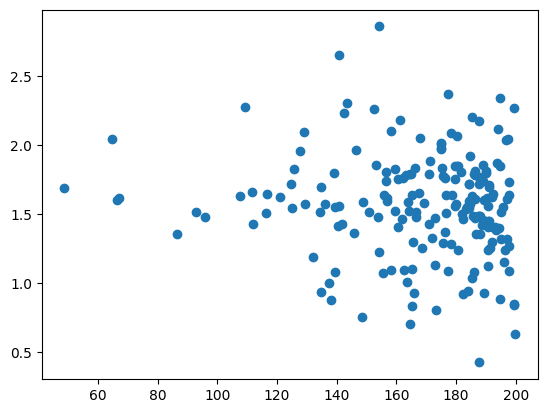

In [13]:
plt.scatter(bad_ds,bad_is)

In [16]:
2*bads/samples

0.382

In [274]:
print(max(all_snrs))

144.6895281552811


(0.0, 150.0)

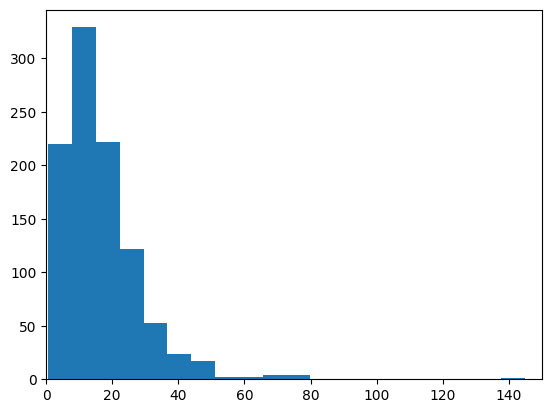

In [275]:
plt.hist(all_snrs, bins = 20)
plt.xlim(0,150)

In [12]:
x = prior.sample(10)

for i in range(len(x['mass1'])):
    if x['mass1'][i] < x['mass2'][i]:
        x['mass2'][i], x['mass1'][i] = x['mass1'][i], x['mass2'][i]


KeyError: 'mass1'

In [ ]:
#from colab notebook

prior = PriorDict()

prior['mass_1'] = 10.0
prior['mass_2'] = 10.0
#prior['chirp_mass'] = 8.70551
#prior['mass_ratio'] = 1.0
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
#prior['geocent_time'] = Uniform(name="geocent_time", minimum=1187008882.4-0.1, maximum=1187008882.4+0.1)
prior['geocent_time'] = 1187008882.4
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
#prior['dec'] =  Uniform(name="dec", minimum=-np.pi/2,maximum=np.pi/2)
prior['dec'] =  Cosine(name="dec", minimum = -np.pi/2,maximum = np.pi/2)
prior['ra'] = Uniform(name="ra", minimum=0,maximum=2*np.pi, boundary= 'periodic')
prior['theta_jn'] =  0
prior['psi'] =  0
prior['luminosity_distance'] = 100

In [80]:
import h5py

approximant = 'SpinTaylorT4'
f_lower = 18.0
delta_t = 1.0/2048
detectors = ['H1','L1']
network_snr_threshold = 6
detector_snr_threshold = 4

n_signal_samples = 1000

all_detectors = {'H1': Detector('H1'), 'L1': Detector('L1'), 'V1': Detector('V1'), 'K1': Detector('K1')}

def get_projected_waveform_mp(args):
    
    hp, hc = get_td_waveform(mass1 = args['mass1'], mass2 = args['mass2'], 
                             spin1z = args['spin1z'], spin2z = args['spin2z'],
                             inclination = args['i'], distance = args['d'],
                             approximant = approximant, f_lower = f_lower, delta_t = delta_t)
    
    #print(len(hp))
    #print(len(hc))
    snrs = {}
    waveforms = {}

    #print(args['ra'],args['dec'])

    for detector in detectors:
        f_plus, f_cross = all_detectors[detector].antenna_pattern(
            right_ascension=args['ra'], declination=args['dec'],
            polarization=args['pol'],
            t_gps=args['gps'])
        
        delta_t_h1 = all_detectors[detector].time_delay_from_detector(
            other_detector=all_detectors['H1'],
            right_ascension=args['ra'],
            declination=args['dec'],
            t_gps=args['gps'])
        

        #print(len(f_plus),len(f_cross),len(hp),len(hc))
        
        detector_signal = f_plus * hp + f_cross * hc

        snr = sigma(htilde=detector_signal,
                    psd=interpolate(psds[detector], delta_f=detector_signal.delta_f),
                    low_frequency_cutoff=f_lower)
        
        snrs[detector] = snr
        waveforms[detector] = detector_signal
        #print(snrs)

    return waveforms, snrs

good_waveforms = []
good_params = []

generated_samples = 0

iteration = 0

waveforms_per_file = 100


while generated_samples < n_signal_samples:

    #generate waveforms_per_file samples at a time, to avoid memory issues.

    p = prior.sample(waveforms_per_file)

    #adding the gps times to the parameters
    p['gps'] = gps[:waveforms_per_file]
    gps = gps[waveforms_per_file:]
    
    params = [{key: p[key][i] for key in p.keys()} for i in range(len(p['mass1']))]

    
    #generate the waveforms

    with mp.Pool(processes = 20) as pool:
        mp_waveforms = pool.map(get_projected_waveform_mp, params)
        #waveforms is a list of lists, where each list is [waveform, snrs]
        #unravel it into two lists

        waveforms, snrs = zip(*mp_waveforms)

    
    #save only the waveforms with network SNR above threshold.
    #save in h5py files with associated parameters.

    for i in range(len(waveforms)):

        network_snr = np.sqrt(sum([snrs[i][detector]**2 for detector in snrs[i]]))

        if network_snr > network_snr_threshold and all([snr > detector_snr_threshold for snr in snrs[i].values()]):
            good_waveforms.append(waveforms[i])
            good_params.append(params[i])
        else:
            print("discarding waveform with SNR " + str(network_snr))

    if iteration == 0 and len(good_waveforms)/waveforms_per_file < 0.5:
        print("WARNING: check your priors!" + str(len(good_waveforms)/waveforms_per_file) + 
              " of the samples meet the SNR threshold.")
    
    #now that we only have the good waveforms, we can save them to file.
    #we don't necessarily have waveforms_per_file samples in good_waveforms, so we need to check that.

    if len(good_waveforms) > waveforms_per_file:
        fname = "configs/test/"+str(iteration*waveforms_per_file)+".hdf5"

        print(fname)
        f = h5py.File(fname,'w')
        for i in range(waveforms_per_file):
            #create group for each waveform
            x = f.create_group(str(i))
            for detector in detectors:
                x.create_dataset(detector, data = good_waveforms[i][detector])

        f.close()

        generated_samples += waveforms_per_file
        iteration +=1


#save the parameters to a file

#convert from a list of dictionaries to a dictionary of lists

good_params_dict = {key: [good_params[i][key] for i in range(len(good_params))] for key in good_params[0].keys()}

np.save("configs/test/params.npy", good_params_dict)

discarding waveform with SNR 2.5394360042944366
discarding waveform with SNR 4.790665505243038
discarding waveform with SNR 1.8133945817406734
discarding waveform with SNR 5.604454485165833
discarding waveform with SNR 5.424834146967024
discarding waveform with SNR 5.990536468983586
discarding waveform with SNR 5.777340139795525
discarding waveform with SNR 7.701493532703937
discarding waveform with SNR 8.207343307354506
discarding waveform with SNR 7.526194702357532
discarding waveform with SNR 8.44108264674351
discarding waveform with SNR 7.203191350732608
discarding waveform with SNR 4.168868891597583
discarding waveform with SNR 4.810766011749553
discarding waveform with SNR 7.518724099831266
discarding waveform with SNR 3.3403994589922283
discarding waveform with SNR 12.030779975482359
discarding waveform with SNR 3.163326159864314
discarding waveform with SNR 1.8439764227987083
discarding waveform with SNR 11.203385672650212
discarding waveform with SNR 7.553075825247603
discardi

In [108]:
#test how quickly we can load the waveforms

for i in range(100):
    with np.load("configs/test/5000.npz") as data:
        w0 = data['arr_'+str(i)]

In [109]:
for i in range(100):
    with np.load("template_banks/BNS_lowspin/5000.npz",mmap_mode='r') as data:
        w0 = data['arr_'+str(i)]

In [7]:
for i in range(1000):
    w0 = np.load("configs/test/0.npz")['arr_'+str(i)]


In [8]:
w0 = np.load("configs/test/0.npz",mmap_mode='r')

In [7]:
hp1, _ = get_td_waveform(mass1 = 1.1, mass2 = 1.1, approximant='SpinTaylorT4', f_lower = 18.0, delta_t = 1/2048)

hp2, _ = get_td_waveform(mass1 = 2, mass2 = 2, approximant='SpinTaylorT4', f_lower = 18.0, delta_t = 1/2048)

In [23]:
waveforms = [hp1, hp2]

In [24]:
np.savez("configs/test/waveforms.npz", *waveforms)

In [27]:
np.load("configs/test/waveforms.npz")['arr_0']

array([-7.50799652e-22, -7.49655404e-22, -7.46225572e-22, ...,
        1.48137182e-20,  1.90810505e-21,  5.96498504e-22])

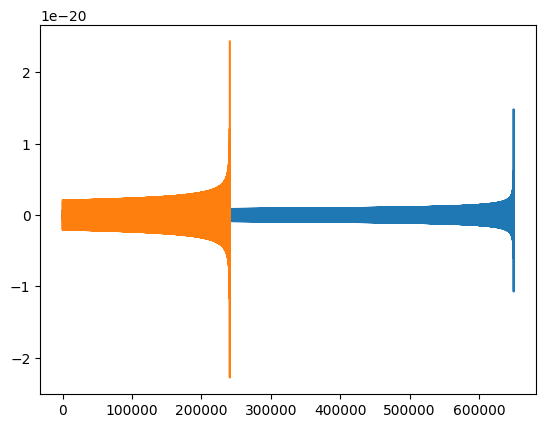

In [9]:
plt.plot(hp1)
plt.plot(hp2)

In [105]:
#load params

waveform_params = np.load("configs/test/params.npy",allow_pickle=True).item(0)

In [106]:
waveform_params.keys()

dict_keys(['mass1', 'mass2', 'spin1z', 'spin2z', 'ra', 'dec', 'd', 'i', 'pol', 'gps'])

In [1]:
from bilby.core.prior import (
    ConditionalPowerLaw,
    ConditionalPriorDict,
    Constraint,
    Cosine,
    Gaussian,
    LogNormal,
    PowerLaw,
    PriorDict,
    Sine,
    Uniform,
)

from bilby.gw.prior import UniformComovingVolume, UniformSourceFrame

In [18]:
Uniform.__name__

'Uniform'

In [1]:
import numpy as np


x = np.array([1,2,3])

x -=1

In [2]:
x

array([0, 1, 2])

In [19]:
#params to save in a json file

n_signal_samples = 1000
n_noise_samples = 1000


approximant = "SpinTaylorT4"
f_lower = 18
delta_t = 1/2048
waveform_length = 1000


detectors = ['H1','L1']

network_snr_threshold = 6
detector_snr_threshold = 4


################################################
#---------------INTRINSIC PARAMS---------------#
################################################


#alpha value to be used for power law priors
powerlaw_alpha = -3.0

#prior functions to use for component masses.
mass1prior = Uniform
mass2prior = Uniform

mass1_min = 1.0
mass1_max = 2.6

mass2_min = 1.0
mass2_max = 2.6

#prior functions to use for spins. 
spin1zprior = Uniform
spin2zprior = Uniform

spin1z_min = 0.0
spin1z_max = 0.0

spin2z_min = 0.0
spin2z_max = 0.0


################################################
#---------------EXTRINSIC PARAMS---------------#
################################################


#prior functions to use for right ascension and declination.
#RA and DEC take ranges 0 <= x <= 1, and are transformed to their proper ranges.

ra_prior = Uniform #RA should always be uniform
dec_prior = Cosine

ra_min = 0.0
ra_max = 1.0

dec_min = 0.0
dec_max = 1.0

#prior function for distance. Should be either Uniform, UniformSourceFrame or UniformComovingVolume.

d_prior = UniformComovingVolume

d_min = 10.0
d_max = 100

#prior function for inclination. Should be Sine.

inc_prior = Sine

inc_min = 0.0
inc_max = 1.0

#prior function for polarization. Should be Uniform.

pol_prior = Uniform

pol_min = 0.0
pol_max = 1.0

#save params in a json file

params = {"n_signal_samples": n_signal_samples,
            "n_noise_samples": n_noise_samples,
            "approximant": approximant,
            "f_lower": f_lower,
            "delta_t": delta_t,
            "waveform_length": waveform_length,
            "detectors": detectors,
            "network_snr_threshold": network_snr_threshold,
            "detector_snr_threshold": detector_snr_threshold,
            "powerlaw_alpha": powerlaw_alpha,
            "mass1prior": mass1prior.__name__,
            "mass2prior": mass2prior.__name__,
            "mass1_min": mass1_min,
            "mass1_max": mass1_max,
            "mass2_min": mass2_min,
            "mass2_max": mass2_max,
            "spin1zprior": spin1zprior.__name__,
            "spin2zprior": spin2zprior.__name__,
            "spin1z_min": spin1z_min,
            "spin1z_max": spin1z_max,
            "spin2z_min": spin2z_min,
            "spin2z_max": spin2z_max,
            "ra_prior": ra_prior.__name__,
            "dec_prior": dec_prior.__name__,
            "ra_min": ra_min,
            "ra_max": ra_max,
            "dec_min": dec_min,
            "dec_max": dec_max,
            "d_prior": d_prior.__name__,
            "d_min": d_min,
            "d_max": d_max,
            "inc_prior": inc_prior.__name__,
            "inc_min": inc_min,
            "inc_max": inc_max,
            "pol_prior": pol_prior.__name__,
            "pol_min": pol_min,
            "pol_max": pol_max}


In [85]:
Uniform

bilby.core.prior.analytical.Uniform

In [87]:
import bilby

In [88]:
getattr(bilby.core.prior, "Uniform")

bilby.core.prior.analytical.Uniform

In [20]:
print(params)

{'n_signal_samples': 1000, 'n_noise_samples': 1000, 'approximant': 'SpinTaylorT4', 'f_lower': 18, 'delta_t': 0.00048828125, 'waveform_length': 1000, 'detectors': ['H1', 'L1'], 'network_snr_threshold': 6, 'detector_snr_threshold': 4, 'powerlaw_alpha': -3.0, 'mass1prior': 'Uniform', 'mass2prior': 'Uniform', 'mass1_min': 1.0, 'mass1_max': 3.0, 'mass2_min': 1.0, 'mass2_max': 3.0, 'spin1zprior': 'Uniform', 'spin2zprior': 'Uniform', 'spin1z_min': 0.0, 'spin1z_max': 0.0, 'spin2z_min': 0.0, 'spin2z_max': 0.0, 'ra_prior': 'Uniform', 'dec_prior': 'Cosine', 'ra_min': 0.0, 'ra_max': 1.0, 'dec_min': 0.0, 'dec_max': 1.0, 'd_prior': 'UniformComovingVolume', 'd_min': 10.0, 'd_max': 100, 'inc_prior': 'Sine', 'inc_min': 0.0, 'inc_max': 1.0, 'pol_prior': 'Uniform', 'pol_min': 0.0, 'pol_max': 1.0}


In [25]:
blah = {"sigs": np.array([1,2,3,4,5,6,7,8,9,10]), "templates": np.arange(100).reshape(10,10)}

In [27]:
np.save("blah.npy", blah)

In [37]:
x = np.load("configs/test/params.npy", allow_pickle=True).item(0)

In [41]:
print(x.keys())

dict_keys(['mass1', 'mass2', 'spin1z', 'spin2z', 'ra', 'dec', 'd', 'i', 'pol', 'gps'])


# GENERATING TEMPLATE BANKS

In [57]:
from pycbc.waveform import get_td_waveform
import multiprocessing as mp
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [58]:
import csv

In [59]:
templates = []
bank_file = open('configs/params.txt','r')
csvFile = csv.reader(bank_file)

for lines in csvFile:
    templates.append([float(i) for i in lines])

templates = np.array(templates)

FileNotFoundError: [Errno 2] No such file or directory: 'configs/params.txt'

In [77]:
templates = np.load("configs/GSTLal_templates.npy")

In [61]:
import os

In [69]:
#directory of all GWSamplegen template banks
main_dir = "/fred/oz016/alistair/GWSamplegen/template_banks/"


#name of template bank directory
bank_dir = "test"

#check if directory exists
if not os.path.exists(main_dir+bank_dir):
    os.mkdir(main_dir+bank_dir)

#priors of the template bank

mass1_min = 1.0
mass1_max = 1.1

mass2_min = 1.0
mass2_max = 1.1

spin1z_min = -1.0
spin1z_max = 1.0

spin2z_min = -1.0
spin2z_max = 1.0

q_min = 0.1
q_max = 1.0


#arguments for waveform generator

approximant = "SpinTaylorT4"
f_lower = 20.0
delta_t = 1/2048

#templates are stored in the form: chirp mass, mass 1, mass 2, spin 1z, spin 2z
templates = np.load(main_dir + "GSTLal_templates.npy")

#select only templates that are within the specified range

templates = templates[(templates[:,1] >= mass1_min) & (templates[:,1] <= mass1_max) & (templates[:,2] >= mass2_min) & 
    (templates[:,2] <= mass2_max) & (templates[:,3] >= spin1z_min) & (templates[:,3] <= spin1z_max) & 
    (templates[:,4] >= spin2z_min) & (templates[:,4] <= spin2z_max) & (templates[:,2]/templates[:,1] >= q_min) & 
    (templates[:,2]/templates[:,1] <= q_max)]

#sort the templates by chrirp mass
templates = templates[templates[:,0].argsort()]

#save the templates for future reference

print(len(templates))
#np.save(main_dir+bank_dir+"/params.npy",templates)


2937


In [70]:
args = {"approximant":approximant,"f_lower":f_lower,"delta_t":delta_t}

In [109]:
#store priors and waveform generation arguments in a dictionary

args = {'approximant': approximant,'f_lower': f_lower,'delta_t': delta_t, 
        'mass1_min': mass1_min,'mass1_max': mass1_max,'mass2_min': mass2_min,'mass2_max': mass2_max,
        'spin1z_min': spin1z_min,'spin1z_max': spin1z_max,'spin2z_min': spin2z_min,'spin2z_max': spin2z_max,
        'q_min': q_min,'q_max': q_max}



In [113]:
#save args to a json file
import json

with open(main_dir+bank_dir+"/args.json", 'w') as fp:
    json.dump(args, fp, sort_keys=False, indent=4)



In [96]:
print(templates.shape)

(651057, 5)


In [12]:
param_list = templates[:1000,1:3]

In [13]:
print(param_list)

[[1.0012846 1.0005911]
 [1.0042679 1.0010313]
 [1.0057804 1.0000049]
 ...
 [1.0382029 1.0185206]
 [1.0567303 1.0008616]
 [1.0421759 1.0147328]]


In [14]:
templates = param_list

In [71]:
#generate gravitational wave signals using multiprocessing

templates_per_file = 100

def get_fd_waveform_mp(args):
    hp, _ = get_td_waveform(mass1 = args[0], mass2 = args[1],
            approximant = "SpinTaylorT4", f_lower = 20, delta_t = 1/2048)
    hp = hp.to_frequencyseries()
    return hp

for j in range(int(np.ceil(len(templates)/100))):

    #handle the case of templates not being divisible by 10
    if j == len(templates)//templates_per_file:
        param_list = templates[j*templates_per_file:,:]
    else:
        param_list = templates[j*templates_per_file:(j+1)*templates_per_file,:]

    print(param_list)


    with mp.Pool(processes = 20) as pool:
        waveforms = pool.map(get_fd_waveform_mp, param_list)

        f = h5py.File("template_banks/test/"+str(j*templates_per_file)+".hdf5",'w')
        for i in range(len(waveforms)):
            f.create_dataset(str(i), data = np.abs(waveforms[i]))

        f.close()

[[ 8.7136695e-01  1.0012846e+00  1.0005911e+00 -2.2768144e-02
  -4.4129732e-02]
 [ 8.7285580e-01  1.0042679e+00  1.0010313e+00 -3.6353967e-02
  -4.5084464e-02]
 [ 8.7306445e-01  1.0057804e+00  1.0000049e+00 -3.9987686e-03
  -2.6449694e-03]
 [ 8.7331117e-01  1.0058122e+00  1.0005383e+00 -3.1478967e-02
  -4.7065840e-02]
 [ 8.7343973e-01  1.0062969e+00  1.0003513e+00 -3.0171209e-02
  -4.3979269e-02]
 [ 8.7357547e-01  1.0057225e+00  1.0012330e+00 -4.9490828e-02
  -1.7095303e-02]
 [ 8.7359277e-01  1.0065194e+00  1.0004807e+00 -7.9676944e-03
   2.2630049e-02]
 [ 8.7362898e-01  1.0054530e+00  1.0016237e+00 -3.5204163e-02
  -4.7377808e-02]
 [ 8.7371560e-01  1.0050922e+00  1.0021816e+00 -4.9169060e-02
  -4.8951220e-02]
 [ 8.7378583e-01  1.0071568e+00  1.0002900e+00 -3.7334457e-02
  -3.9739325e-02]
 [ 8.7380042e-01  1.0069068e+00  1.0005714e+00  4.0706114e-02
   4.0815950e-02]
 [ 8.7383740e-01  1.0047486e+00  1.0028037e+00 -4.9947297e-02
  -4.3344226e-02]
 [ 8.7396478e-01  1.0077341e+00  1.00012

In [ ]:
#for a 2.1 GB file, takes ~0.2 seconds per template load
#for a 1.1 GB file, takes ~0.12 seconds per template load
#for a 95 MB file, takes ~0.06 seconds per template load

In [25]:
def get_td_waveform_mp(args):
    hp, _ = get_td_waveform(mass1 = args[0], mass2 = args[1],
            approximant = "SpinTaylorT4", f_lower = 20, delta_t = 1/2048)
    #hp = hp.to_frequencyseries()
    return hp

In [39]:
x = get_fd_waveform_mp(param_list[200])

In [40]:
len(x)

123599

In [33]:
len(x)

120962

In [73]:
chirp_mass = ((param_list[:,0]*param_list[:,1])**(3/5))/((param_list[:,0]+param_list[:,1])**(1/5))

In [71]:
def chirp_mass(m1,m2):
    return ((m1*m2)**(3/5))/((m1+m2)**(1/5))

In [72]:
chirp_mass(2.329243,1.2128739)

1.4479904304743263

In [68]:
chirp_mass(param_list[300][0],param_list[300][1])

2.030727394475278

In [69]:
param_list[300]

array([2.3292431, 1.2128739])

In [65]:
param_list[:,1][300]

1.2128739

In [66]:
chirp_mass[300]

2.030727394475278

In [42]:
param_list[150]

array([2.827095 , 1.0272239])

In [41]:
param_list[200] #long

array([2.0452294, 1.3631185])

In [43]:
param_list[250]

array([2.6187289, 1.095811 ])

In [44]:
param_list[300] #long

array([2.3292431, 1.2128739])

In [5]:
file_index = 1

templates_per_file = 1000


print("template_banks/BNS_nonspin/"+str(file_index*templates_per_file)+".hdf5")

template_banks/BNS_nonspin/1000.hdf5


In [17]:
import matplotlib.pyplot as plt

In [79]:
import os

os.listdir("template_banks/BNS_nonspin/")

os.remove("template_banks/BNS_nonspin/0.hdf5")
os.remove("template_banks/BNS_nonspin/1.hdf5")
os.remove("template_banks/BNS_nonspin/2.hdf5")